In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import datetime as dt
import math as mt

In [2]:
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

In [3]:
PATH = ''

### Load Data and Inspect

In [4]:
X_train = pd.read_csv(PATH+"X_train.csv")
X_train = X_train.drop(X_train.columns[-1],axis=1)
X_train.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
y_train = pd.read_csv(PATH+"y_train.csv")
y_train.head(5)

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [6]:
X_test = pd.read_csv(PATH+"X_test.csv")
X_test = X_test.drop(X_test.columns[-1],axis=1)
X_test.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2014-01-01T00:00:00.0,312.2222,30.0,8.4,86.0,8.4,5.6,17.0,1016.6
1,2014-01-01T00:01:00.0,318.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01T00:02:00.0,314.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01T00:03:00.0,311.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01T00:04:00.0,310.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train = X_train.sort_values(by="time_step")
y_train = y_train.sort_values(by="time_step")

### Missing Value Imputation

In [8]:
sample1 = X_train.interpolate(method='linear')
sample1 = sample1.interpolate(method='linear', limit_direction='both')
sample1['consumption'] = X_train['consumption']
X_train_imputed = sample1.copy()
X_train_imputed.isna().sum()

time_step          0
consumption    10231
visibility         0
temperature        0
humidity           0
humidex            0
windchill          0
wind               0
pressure           0
dtype: int64

In [9]:
X_train_imputed_5min = X_train_imputed.interpolate(method='nearest', limit_direction='forward', limit=5)

In [10]:
sample2 = X_test.interpolate(method='linear')
sample2 = sample2.interpolate(method='linear', limit_direction='both')
sample2['consumption'] = X_test['consumption']
X_test_imputed = sample2.copy()

In [11]:
y_train_imputed_5min = y_train.interpolate(method='nearest', limit_direction='forward', limit=5)

In [12]:
X_train_A = X_train_imputed_5min.copy()
X_test_A = X_test_imputed.copy()
y_train_A = y_train_imputed_5min.copy()

### Data Integration

In [13]:
train = pd.merge(X_train_A, y_train_A,
                 how="left",
                 left_on=['time_step'],
                 right_on=['time_step'],
                 sort=False
                )

### Visualization

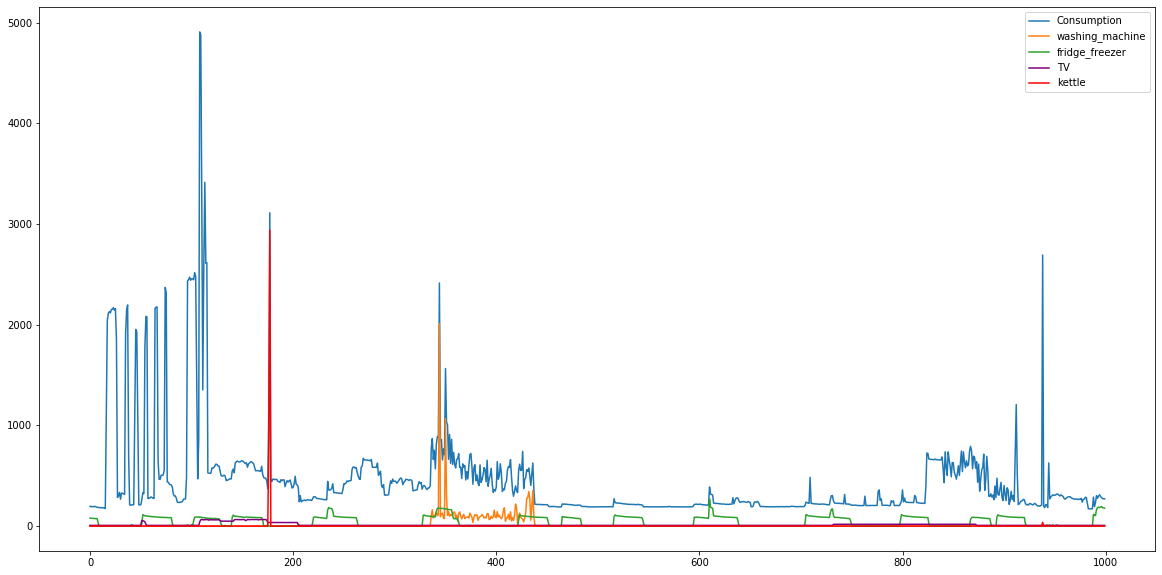

In [14]:
fig = plt.figure(figsize=(20,10))

size = 1000
start = 2400

plot_sample = train.iloc[start:start+size,:]
plt.plot(np.arange(0,size,1), plot_sample['consumption'], label='Consumption')
plt.plot(np.arange(0,size,1), plot_sample['washing_machine'], label='washing_machine')
plt.plot(np.arange(0,size,1), plot_sample['fridge_freezer'], label='fridge_freezer')
plt.plot(np.arange(0,size,1), plot_sample['TV'], label='TV', color="purple")
plt.plot(np.arange(0,size,1), plot_sample['kettle'], label='kettle', color="red")

plt.legend()

plt.show()

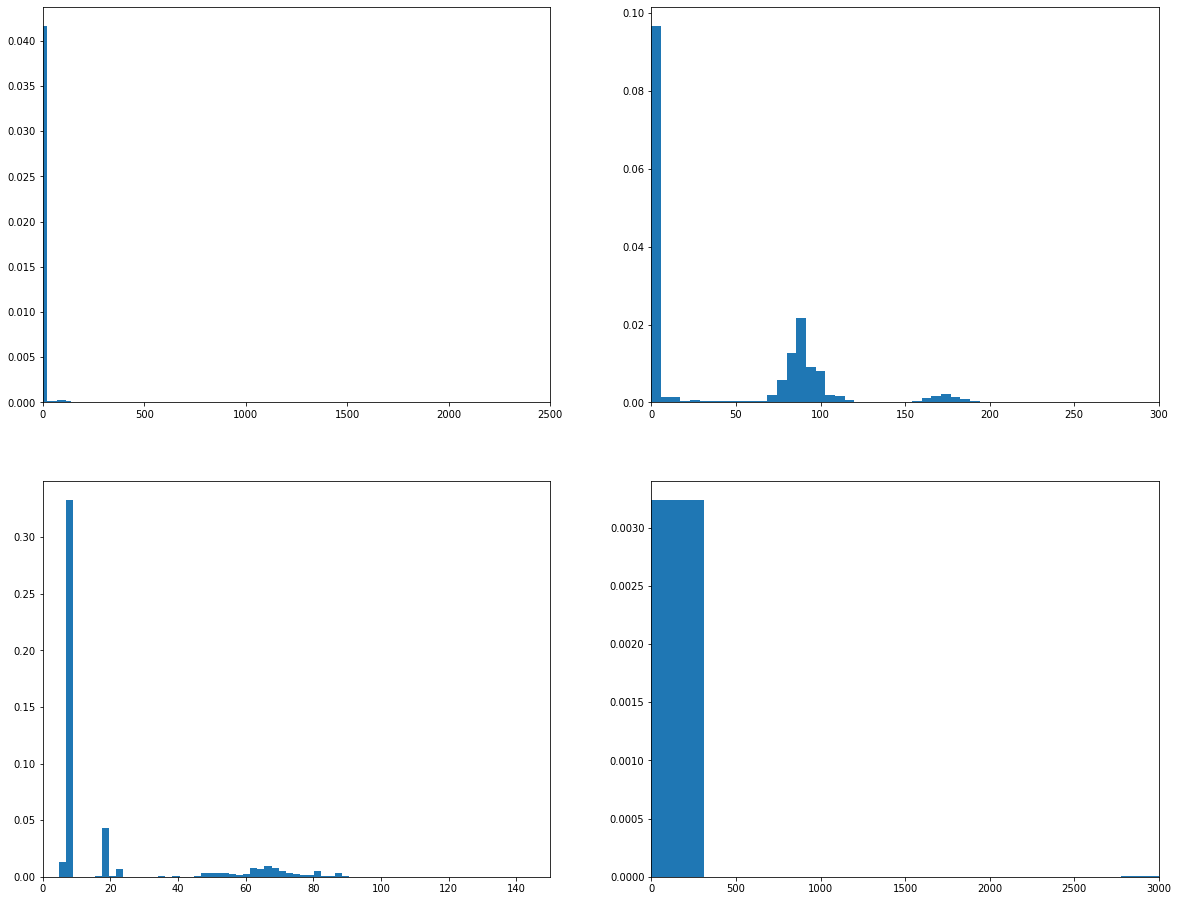

In [15]:
plt.figure(1,figsize = (20,16))

size = 50000
plot_sample = train.iloc[:size,:]

plt.subplot(221)
plt.hist(plot_sample.washing_machine, bins=100, density=True)
plt.xlim(0,2500)

plt.subplot(222)
plt.hist(plot_sample.fridge_freezer, bins=50, density=True)
plt.xlim(0,300)

plt.subplot(223)
plt.hist(plot_sample.TV, bins=50, density=True)
plt.xlim(0,150)

plt.subplot(224)
plt.hist(plot_sample.kettle, bins=10, density=True)
plt.xlim(0,3000)

plt.show()

In [16]:
sample_washing_machine = list(plot_sample.washing_machine[(plot_sample.washing_machine.notnull()) & (plot_sample.washing_machine >= 10)])

### Feature Engineering

1. Given features

In [17]:
X_vars = ['consumption', 'visibility', 'temperature', 'humidity','humidex',
                   'windchill', 'wind', 'pressure']
y_vars = ['washing_machine','fridge_freezer','TV','kettle']

2. Derived time features

In [18]:
train['date'] = train['time_step'].str[:10]
train['hour'] = train['time_step'].str[11:13].astype('int')
train['minute'] = train['time_step'].str[14:16].astype('int')

train['date'] = pd.to_datetime(train['date'], infer_datetime_format=True)

train['dayofweek'] = train['date'].dt.dayofweek

In [19]:
isweekend = []
for day in list(train['dayofweek']):
    if day in [5,6]:
        isweekend.append(1)
    else:
        isweekend.append(0)
train['isweekend'] = isweekend

In [20]:
train = pd.concat([train, pd.get_dummies(train['dayofweek'], prefix='day'),
                           pd.get_dummies(train['hour'], prefix='hour')], axis=1)

In [21]:
train['hour_sin'] = np.sin((train['hour'] + 1) * 360. / 24. * np.pi / 180. )
train['hour_cos'] = np.cos((train['hour'] + 1) * 360. / 24. * np.pi / 180. )

train['minute_sin'] = np.sin((train['minute'] + 1) * 360. / 60. * np.pi / 180. )
train['minute_cos'] = np.cos((train['minute'] + 1) * 360. / 60. * np.pi / 180. )

In [22]:
train.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'washing_machine',
       'fridge_freezer', 'TV', 'kettle', 'date', 'hour', 'minute', 'dayofweek',
       'isweekend', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos'],
      dtype='object')

3. PCA of weather features

In [23]:
### PCA of weather data
from sklearn.decomposition import PCA

PCA_features = ['visibility', 'temperature', 'humidity', 'humidex', 'windchill', 'wind', 'pressure']
PCA_data = train[PCA_features]

pca = PCA(n_components=3)
pca3_feature = pca.fit_transform(PCA_data)
print(pca.explained_variance_ratio_)

[0.75843957 0.13448329 0.05984582]


In [24]:
train['WeatherPCA1'] = pca3_feature[:,0]
train['WeatherPCA2'] = pca3_feature[:,1]
train['WeatherPCA3'] = pca3_feature[:,2]

In [25]:
train.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'washing_machine',
       'fridge_freezer', 'TV', 'kettle', 'date', 'hour', 'minute', 'dayofweek',
       'isweekend', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'WeatherPCA1', 'WeatherPCA2',
       'WeatherPCA3'],
      dtype='object')

4. Window states

**Window Sizes**:  
Kettle - 3mins; margin - 1min; 2600 fridge_freezer - 35mins; margin - 3mins;  
TV - 150mins; margin - 5mins;  
washing_machine - 100mins; margin - 5mins; 1800

In [26]:
### Windows with margin
def window_diff(series, start_pos, size, margin):
    starting_avg = np.mean(series[start_pos:start_pos+margin])
    ending_avg = np.mean(series[start_pos+size-margin:start_pos+size])
    return ending_avg - starting_avg

def window_state(series, start_pos, size, margin, threshold):
    diff = window_diff(series, start_pos, size, margin)
    if diff > threshold:
        return 1
    elif diff < -threshold:
        return -1
    else:
        return 0

def window_update(series, size, margin, threshold):
    states = pd.Series(len(series)*[0])
    for i in range(len(series)-size+1):
        if i % 5000 == 0:
            print(i)
        states[i:i+size] = window_state(series, i, size, margin, threshold)
    return states

In [27]:
train['is_kettle_2500'] = window_update(train['consumption'], 3, 1, 2500)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000


In [ ]:
train['is_kettle_2700'] = window_update(train['consumption'], 3, 1, 2700)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000


In [ ]:
train['is_washing_1800_5'] = window_update(train['consumption'], 100, 5, 1800)

In [ ]:
train['is_washing_2000_10'] = window_update(train['consumption'], 100, 10, 2000)

5. Feature grouping

In [91]:
X_vars_base = ['consumption']
X_vars_day = ['isweekend', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
X_vars_hour1 = ['hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour
                
                _10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23']
X_vars_hour2 = ['hour_sin', 'hour_cos']
X_vars_weather1 = ['visibility', 'temperature', 'humidity',
                   'humidex', 'windchill', 'wind', 'pressure']
X_vars_weather2 = ['WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3']

### Invalid Data Filtering

In [ ]:
train_notnull = train[train['consumption'].notna()]

### Linear Model

In [92]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [137]:
X_vars_set = X_vars_base+X_vars_day+X_vars_hour2

In [138]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [139]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('Train size: {train}, Test size: {test}'.format(train=x_train.shape[0], test=x_test.shape[0]))

Train size: 368649, Test size: 40961


In [140]:
x_train.columns

Index(['time_step', 'consumption', 'isweekend', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'hour_sin', 'hour_cos'],
      dtype='object')

In [141]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train[x_train.columns[1:]])
y_scaled = scaler.fit_transform(y_train)

In [142]:
len(y_scaled[:,0])

368649

1 - washing_machine; 2 - fridge_freezer; 3 - TV; 4 - kettle;

In [143]:
y_pred = x_test[['time_step']]

In [144]:
reg1 = LinearRegression().fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = reg1.predict(x_test[X_vars_set])

reg2 = LinearRegression().fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = reg2.predict(x_test[X_vars_set])

reg3 = LinearRegression().fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = reg3.predict(x_test[X_vars_set])

reg4 = LinearRegression().fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = reg4.predict(x_test[X_vars_set])

In [145]:
metric_nilm(y_test, y_pred)

73.5590971290617

### ELM / Hierarchical-ELMs (H-ELMs)

In [33]:
! pip install sklearn --upgrade
import sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=7ff64bcff4b45fbc795fc83905d2fde124c608444cda24d3fadfe514f7a2dbd1
  Stored in directory: /Users/FerdinandYu/Library/Caches/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [146]:
from elm2 import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.linear_model import LinearRegression

In [147]:
X_vars_set = X_vars_base+X_vars_day+X_vars_hour2+X_vars_weather2

In [155]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [156]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print('Train size: {train}, Test size: {test}'.format(train=x_train.shape[0], test=x_test.shape[0]))

Train size: 368649, Test size: 40961


In [157]:
x_train.columns

Index(['time_step', 'consumption', 'isweekend', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'hour_sin', 'hour_cos',
       'WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3'],
      dtype='object')

In [158]:
x_scaled = scaler.fit_transform(x_train[x_train.columns[1:]])
y_scaled = scaler.fit_transform(y_train)

In [159]:
y_pred = x_test[['time_step']]

In [175]:
elmr = ELMRegressor(random_state=0, n_hidden=32, activation_func='sigmoid', alpha=0.5)

elmr1 = elmr.fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = elmr1.predict(x_test[X_vars_set])

elmr2 = elmr.fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_test[X_vars_set])

elmr3 = elmr.fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = elmr3.predict(x_test[X_vars_set])

elmr4 = elmr.fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = elmr4.predict(x_test[X_vars_set])

In [176]:
metric_nilm(y_test, y_pred)

62.53772806372715

In [183]:
elmr = pipeline.Pipeline([('rhl', RandomLayer(random_state=0, n_hidden=64, activation_func='sigmoid', alpha=0.5)),
                          ('rh2', RandomLayer(random_state=0, n_hidden=64, activation_func='sigmoid', alpha=0.5)),
                          ('lr', LinearRegression(fit_intercept=False))])

elmr1 = elmr.fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = elmr1.predict(x_test[X_vars_set])

elmr2 = elmr.fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_test[X_vars_set])

elmr3 = elmr.fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = elmr3.predict(x_test[X_vars_set])

elmr4 = elmr.fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = elmr4.predict(x_test[X_vars_set])

In [184]:
metric_nilm(y_test, y_pred)

63.18702435746567

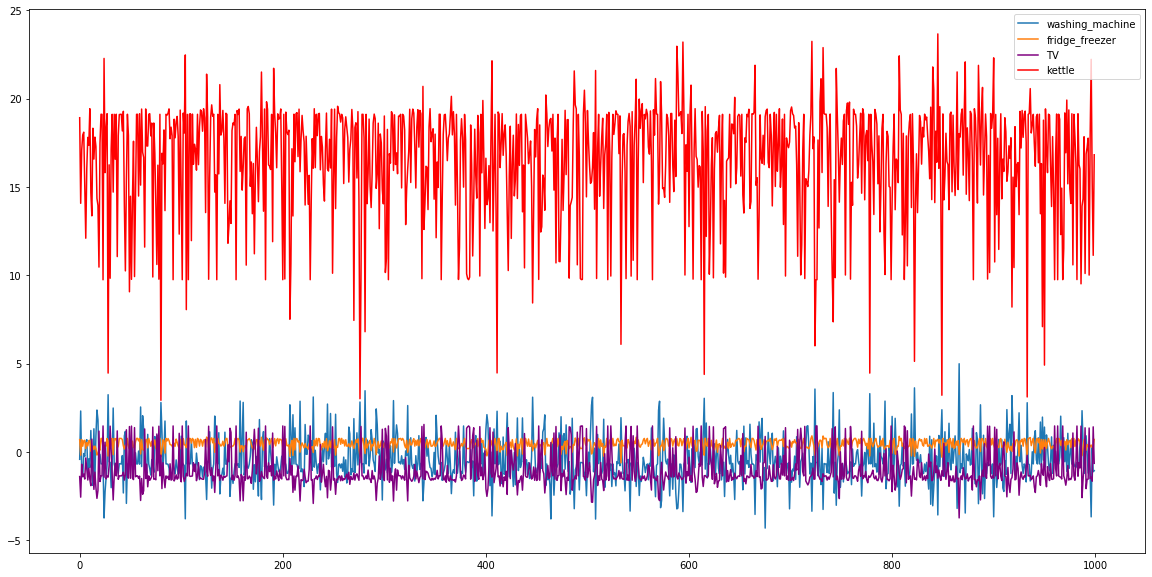

In [269]:
fig = plt.figure(figsize=(20,10))

size = 1000
start = 5400

plot_sample = y_pred.iloc[start:start+size,:]
#plt.plot(np.arange(0,size,1), plot_sample['consumption'], label='Consumption')
plt.plot(np.arange(0,size,1), plot_sample['washing_machine'], label='washing_machine')
plt.plot(np.arange(0,size,1), plot_sample['fridge_freezer'], label='fridge_freezer')
plt.plot(np.arange(0,size,1), plot_sample['TV'], label='TV', color="purple")
plt.plot(np.arange(0,size,1), plot_sample['kettle'], label='kettle', color="red")

plt.legend()

plt.show()

### XGBoost

In [294]:
import xgboost as xgb
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from scipy import stats

In [ ]:
X_vars_set = X_vars_base+X_vars_day+X_vars_hour2+X_vars_weather2

In [ ]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print('Train size: {train}, Validation size: {test}'.format(train=x_train.shape[0], test=x_valid.shape[0]))

In [ ]:
params = {'objective':'reg:squarederror',
                    'max_depth':7,
                    'n_estimators':1000,
                    'n_jobs':4,
                    'min_child_weight': 7, 'max_depth': 5
                    }
clf = xgb.XGBRegressor(**params)
scr = preprocessing.StandardScaler()
x_scaled = scr.fit_transform(x_train)

rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_squared_error',verbose = True)   #5-fold cross-validation
rfecv = rfecv.fit(X_array_std, y_array)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', fe.getDF().columns[rfecv.support_])

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
class XGB_Regressor(BaseEstimator):
    def __init__(self):
        self.scr = preprocessing.StandardScaler()
        #0.45
        self.param ={'objective':'reg:squarederror',
                    'max_depth':7,
                    'n_estimators':1000,
                    'n_jobs':4,
                     'min_child_weight': 7, 'max_depth': 5
                    }
        self.reg = xgb.XGBRegressor(**self.param)
        
        #self.reg = xgb.XGBRegressor()

    def fit(self, X, y):
        X = self.scr.fit_transform(X)
        self.reg.fit(X, y)

    def predict(self, X):
        X = self.scr.transform(X)
        return self.reg.predict(X)

In [ ]:
def model_cv(model, X, y, cv_folds=5, early_stopping_rounds=50, seed=42):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X, label=y)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='rmse', seed=seed, callbacks=[
            xgb.callback.print_evaluation(show_stdv=False),
            xgb.callback.early_stop(early_stopping_rounds)
       ])
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)
    return num_round_best

In [ ]:
param ={'objective':'reg:squarederror',
                    'max_depth':7,
                    'n_estimators':1000,
                    'n_jobs':4,
                     'min_child_weight': 7, 'max_depth': 5
                    }

reg3 = xgb.XGBRegressor(**param)
        
        
scr = preprocessing.StandardScaler()
X_array_std = scr.fit_transform(X_array)
model_cv(reg3, X_array, y_array)